In [1]:
import gurobipy as grb
import networkx as nx
import numpy as np

# Function Definitions
def mycallback(model, where):
    if where == grb.GRB.Callback.MIP:
        # General MIP callback
        objbst = model.cbGet(grb.GRB.Callback.MIP_OBJBST)
        objbnd = model.cbGet(grb.GRB.Callback.MIP_OBJBND)
        time = model.cbGet(grb.GRB.Callback.RUNTIME)
        if(time>300 and abs(objbst - objbnd) < 0.005 * (1.0 + abs(objbst))):
            print('Stop early - 0.50% gap achieved time exceeds 5 minutes')
            model.terminate()
        elif(time>60 and abs(objbst - objbnd) < 0.0025 * (1.0 + abs(objbst))):
            print('Stop early - 0.25% gap achieved time exceeds 1 minute')
            model.terminate()
        elif(time>1200 and abs(objbst - objbnd) < 0.01 * (1.0 + abs(objbst))):
            print('Stop early - 1.00% gap achieved time exceeds 20 minutes')
            model.terminate()
        elif(time>1800 and abs(objbst - objbnd) < 0.05 * (1.0 + abs(objbst))):
            print('Stop early - 5.00% gap achieved time exceeds 30 minutes')
            model.terminate()
        elif(time>2400 and abs(objbst - objbnd) < 0.1 * (1.0 + abs(objbst))):
            print('Stop early - 10.0% gap achieved time exceeds 40 minutes')
            model.terminate()
    return


# Class Definitions
class MILP_secondary:
    """
    """
    def __init__(self,graph,roots,hops):
        """
        """
        self.edges = list(graph.edges())
        self.nodes = list(graph.nodes())
        print("Number of edges:",len(self.edges))
        self.hindex = [i for i,node in enumerate(self.nodes) if node not in roots]
        self.tindex = [i for i,node in enumerate(self.nodes) if node in roots]
        self.A = nx.incidence_matrix(graph,nodelist=self.nodes,
                                     edgelist=self.edges,oriented=True)
        self.I = nx.incidence_matrix(graph,nodelist=self.nodes,
                                     edgelist=self.edges,oriented=False)
        COST = nx.get_edge_attributes(graph,name='cost')
        LENGTH = nx.get_edge_attributes(graph,name='length')
        LOAD = nx.get_node_attributes(graph,name='load')
        self.c = np.array([1e-3*COST[e] for e in self.edges])
        self.l = np.array([1e-3*LENGTH[e] for e in self.edges])
        self.p = np.array([1e-3*LOAD[self.nodes[i]] for i in self.hindex])
        self.model = grb.Model(name="Get Spiders")
        self.model.ModelSense = grb.GRB.MINIMIZE
        self.__variables()
        self.__radiality()
        self.__heuristic()
        self.__powerflow()
        self.__objective()
        self.model.write("secondary.lp")
        self.optimal_edges = self.__solve()
        return
    
    def __variables(self):
        """
        Create variable initialization for MILP such that x is binary, f is a 
        continuous variable.
        """
        self.x = self.model.addMVar(len(self.edges),
                                    vtype=grb.GRB.BINARY,name='x')
        self.f = self.model.addMVar(len(self.edges),
                                    vtype=grb.GRB.CONTINUOUS,
                                    lb=-grb.GRB.INFINITY,name='f')
        self.z = self.model.addMVar(len(self.edges),
                                    vtype=grb.GRB.CONTINUOUS,
                                    lb=-grb.GRB.INFINITY,name='z')
        self.v = self.model.addMVar(len(self.nodes),
                                    vtype=grb.GRB.CONTINUOUS,
                                    lb=0.95,ub=1.00,name='v')
        self.model.update()
        return
    
    def __radiality(self):
        """
        Radiality constraints in the form of linear problem are defined:
            1. Number of edges of a forest is number of nodes except root
            2. Each connected component of forest should have a transformer
        """
        print("Setting up radiality constraints")
        self.model.addConstr(self.x.sum() == len(self.hindex), name="radiality")
        self.model.update()
        return
    
    def __heuristic(self,M=10):
        """
        """
        self.model.addConstr(
            self.A[self.hindex,:]@self.z == -np.ones(shape=(len(self.hindex),)),
            name = 'connectivity')
        self.model.addConstr(self.z - M*self.x <= 0,name="hop_a")
        self.model.addConstr(self.z + M*self.x >= 0,name="hop_b")
        self.model.addConstr(
            self.I[self.hindex,:]@self.x <= 2*np.ones(shape=(len(self.hindex),)),
            name = 'degree')
        self.model.update()
        return
    
    def __powerflow(self,r=0.81508/57.6,M=25):
        """
        """
        print("Setting up power flow constraints")
        self.model.addConstr(self.A[self.hindex,:]@self.f == -self.p,name='balance')
        self.model.addConstr(self.f - M*self.x <= 0,name="flow_a")
        self.model.addConstr(self.f + M*self.x >= 0,name="flow_b")
        expr = r*np.diag(self.l)@self.f
        self.model.addConstr(self.A.T@self.v - expr - 0.1*(1-self.x) <= 0,name='va')
        self.model.addConstr(self.A.T@self.v - expr + 0.1*(1-self.x) >= 0,name='vb')
        for i in self.tindex:
            self.model.addConstr(self.v[i]==1,name="voltage")
        self.model.update()
        return
    
    def __objective(self):
        """
        """
        self.model.setObjective(self.c @ self.x)
        self.model.update()
        return
    
    def __solve(self):
        """
        """
        # Turn off display and heuristics
        grb.setParam('OutputFlag', 1)
        grb.setParam('Heuristics', 0)
        
        # Open log file
        logfile = open('gurobi.log', 'w')
        
        # Pass data into my callback function
        self.model._lastiter = -grb.GRB.INFINITY
        self.model._lastnode = -grb.GRB.INFINITY
        self.model._logfile = logfile
        self.model._vars = self.model.getVars()
        
        # Solve model and capture solution information
        self.model.optimize(mycallback)
        
        # Close log file
        logfile.close()
        print('')
        print('Optimization complete')
        if self.model.SolCount == 0:
            print('No solution found, optimization status = %d' % self.model.Status)
            sys.exit(0)
        else:
            print('Solution found, objective = %g' % self.model.ObjVal)
            x_optimal = self.x.getAttr("x").tolist()
            return [e for i,e in enumerate(self.edges) if x_optimal[i]>0.5]

In [5]:
# Import necessary modules
from geographiclib.geodesic import Geodesic
from shapely.geometry import LineString,MultiPoint
from scipy.spatial import Delaunay
from itertools import combinations


# Function definition
def MeasureDistance(pt1,pt2):
    '''
    Measures the geodesic distance between two coordinates. The format of each point 
    is (longitude,latitude).
    pt1: (longitude,latitude) of point 1
    pt2: (longitude,latitude) of point 2
    '''
    lon1,lat1 = pt1
    lon2,lat2 = pt2
    geod = Geodesic.WGS84
    return geod.Inverse(lat1, lon1, lat2, lon2)['s12']

def InvertMap(input_dict):
    """
    Inverts a given mapping. The input/output mapping is provided through a dictionary.
    input_dict: input mapping
    output_dict: output mapping
    """
    output_dict = {}
    for key in input_dict:
        if input_dict[key] in list(output_dict.keys()):
            output_dict[input_dict[key]].append(key)
        else:
            output_dict[input_dict[key]]=[key]
    return output_dict



# Class definition for geometry shapes
class Link(LineString):
    """
    Derived class from Shapely LineString to compute metric distance based on 
    geographical coordinates over geometric coordinates.
    """
    def __init__(self,line_geom):
        """
        Initialize class object through inheritence
        """
        super().__init__(line_geom)
        self.geod_length = self.__length()
        return
    
    
    def __length(self):
        '''
        Computes the geographical length in meters between the ends of the link.
        '''
        if self.geom_type != 'LineString':
            print("Cannot compute length!!!")
            return None
        # Compute great circle distance
        lon1,lon2 = self.xy[0]
        lat1,lat2 = self.xy[1]
        geod = Geodesic.WGS84
        return geod.Inverse(lat1, lon1, lat2, lon2)['s12']
    
    
    def InterpolatePoints(self,min_sep=50):
        """
        Interpolate multiple points in between the line segment
        """
        points = []
        length = self.geod_length
        sep = max(min_sep,(length/15))
        for i in np.arange(0,length,sep):
            x,y = self.interpolate(i/length,normalized=True).xy
            xy = (x[0],y[0])
            points.append(xy)
        return {i:[pt.x,pt.y] for i,pt in enumerate(MultiPoint(points))}

class Spider:
    """
    Contains methods and attributes to generate the secondary distribution network
    originating from a link. The link consists of multiple transformers and uses 
    multiple engineering and economic heuristics to generate the network.
    """
    def __init__(self,homes,roads,home_to_link):
        """
        Initializes the class object with all home nodes, road network and the mapping
        between them.
        
        Input:  homes: named tuple with all residential building data
                roads: named tuple with all road network information
                home_to_link: mapping between homes and road links
        """
        self.home_load = homes.average
        self.home_cord = homes.cord
        self.road_cord = roads.cord
        self.link_to_home = InvertMap(home_to_link)
        return
    
    
    def __separate_side(self,link):
        """
        Evaluates the groups of homes on either side of the link. This would help in 
        creating network with minimum crossover of distribution lines over the road
        network.
        
        Input: link: the road link of interest
        Output: side: dictionary of homes as keys and value as 1 or -1 depending on
                which side of the link it is present.
        """
        homelist = self.link_to_home[link] if link in self.link_to_home\
            else self.link_to_home[(link[1],link[0])]
        points = [self.home_cord[h] for h in homelist]
        (x1,y1) = self.road_cord[link[0]]
        (x2,y2) = self.road_cord[link[1]]
        eqn = [((x-x1)*(y2-y1))-((y-y1)*(x2-x1)) for (x,y) in points]
        side = {home: 1 if eqn[index]>=0 else -1 for index,home in enumerate(homelist)}
        return side
    
    
    def __complete_graph_from_list(self,L):
        """
        Computes the full graph of the nodes in list L. There would be L(L-1)/2 edges 
        in the network. This is used as base network when the number of nodes mapped 
        to the link is small.
        
        Input: L: list of nodes mapped to the link of interest
        Output: graph: the full graph which would be used as base network for the 
                optimization problem.
        """
        G = nx.Graph()
        edges = combinations(L,2)
        G.add_edges_from(edges)
        return G
    
    def __delaunay_graph_from_list(self,L):
        """
        Computes the Delaunay graph of the nodes in list L. L edges in the network 
        based on the definition of Delaunay triangulation. This is used as base 
        network when the number of nodes mapped to the link is small.
        
        Input: L: list of nodes mapped to the link of interest
        Output: graph: the Delaunay graph which would be used as base network for the 
                optimization problem.
        """
        points = np.array([[self.home_cord[h][0],
                            self.home_cord[h][1]] for h in L])
        triangles = Delaunay(points).simplices
        edgelist = []
        for t in triangles:
            edges = [(L[t[0]],L[t[1]]),(L[t[1]],L[t[2]]),(L[t[2]],L[t[0]])]
            edgelist.extend(edges)
        G = nx.Graph()
        G.add_edges_from(edgelist)
        return G
    
    
    def create_dummy_graph(self,link,minsep,penalty):
        """
        Creates the base network to carry out the optimization problem. The base graph
        may be a Delaunay graph or a full graph depending on the size of the problem.
        
        Inputs: link: road link of interest for which the problem is solved.
                minsep: minimum separation in meters between the transformers.
                penalty: penalty factor for crossing the link.
        Outputs:graph: the generated base graph also called the dummy graph
                transformers: list of points along link which are probable locations 
                of transformers.
        """
        sides = self.__separate_side(link)
        home_pts = self.link_to_home[link]
        node_pos = {h:self.home_cord[h] for h in home_pts}
        load = {h:self.home_load[h]/1000.0 for h in home_pts}
                
        # Update the attributes of nodes
        link_line = Link(LineString([tuple(self.road_cord[n]) for n in link]))
        transformers = link_line.InterpolatePoints(minsep)
        node_pos.update(transformers)
        sides.update({t:0 for t in transformers})
        load.update({t:1.0 for t in transformers})
        
        # Create the base graph
        if len(home_pts)>10:
            graph = self.__delaunay_graph_from_list(home_pts)
        else:
            graph = self.__complete_graph_from_list(home_pts)
        new_edges = [(t,n) for t in transformers for n in home_pts]
        graph.add_edges_from(new_edges)
        nx.set_node_attributes(graph,node_pos,'cord')
        nx.set_node_attributes(graph,load,'load')
        edge_cost = {e:MeasureDistance(node_pos[e[0]],node_pos[e[1]])*\
                     (1+penalty*abs(sides[e[0]]-sides[e[1]])) \
                      for e in list(graph.edges())}
        edge_length = {e:MeasureDistance(node_pos[e[0]],node_pos[e[1]])\
                      for e in list(graph.edges())}
        nx.set_edge_attributes(graph,edge_length,'length')
        nx.set_edge_attributes(graph,edge_cost,'cost')
        return graph,transformers
    
    def get_nodes(self,link,minsep):
        """
        Gets all the nodes from the dummy graph created before solving the optimization 
        problem.
        
        Inputs: link: road link of interest for which the problem is solved.
                minsep: minimum separation in meters between the transformers.
        Outputs:home_pts: list of residential points
                transformers: list of points along link which are probable locations 
                of transformers.
        """
        home_pts = self.link_to_home[link]
        if len(home_pts) > 100:
            link_line = Link(LineString([tuple(self.road_cord[n]) for n in link]))
            transformers = link_line.InterpolatePoints(minsep)
        else:
            link_line = Link(LineString([tuple(self.road_cord[n]) for n in link]))
            transformers = link_line.InterpolatePoints(minsep)
        return home_pts,transformers
    
    def generate_optimal_topology(self,link,minsep=50,penalty=0.5,hops=4):
        """
        Calls the MILP problem and solves it using gurobi solver.
        
        Inputs: link: road link of interest for which the problem is solved.
                minsep: minimum separation in meters between the transformers.
                penalty: penalty factor for crossing the link.
        Outputs:forest: the generated forest graph which is the secondary network
                roots: list of points along link which are actual locations of 
                transformers.
        """
        graph,roots = self.create_dummy_graph(link,minsep,penalty)
        edgelist = MILP_secondary(graph,roots,hops).optimal_edges
        forest = nx.Graph()
        forest.add_edges_from(edgelist)
        node_cord = {node: roots[node] if node in roots\
                     else self.home_cord[node]\
                     for node in list(forest.nodes())}
        nx.set_node_attributes(forest,node_cord,'cord')
        node_load = {node:sum([self.home_load[h] for h in list(nx.descendants(forest,node))]) \
                     if node in roots else self.home_load[node] for node in list(forest.nodes())}
        nx.set_node_attributes(forest,node_load,'load')
        return forest,roots


In [6]:
# Import necessary modules
import sys,os
import pandas as pd
import matplotlib.pyplot as plt

# Define paths to required directories
workPath = os.getcwd()
inpPath = workPath + "/input/"
libPath = workPath + "/Libraries/"
csvPath = workPath + "/csv/"
figPath = workPath + "/figs/"

sys.path.append(libPath)
from pyExtractDatalib import Query

# Extract data from directories
q_object = Query(csvPath)
gdf_home,homes = q_object.GetHomes()
roads = q_object.GetRoads()

df_hmap = pd.read_csv(csvPath+'home2link.csv')
H2Link = dict([(t.HID, (t.source, t.target)) for t in df_hmap.itertuples()])
spider_obj = Spider(homes,roads,H2Link)
L2Home = spider_obj.link_to_home

Number of edges: 387
Setting up radiality constraints
Setting up power flow constraints
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Parameter Heuristics unchanged
   Value: 0.0  Min: 0.0  Max: 1.0  Default: 0.05
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 2411 rows, 1199 columns and 7939 nonzeros
Model fingerprint: 0x78b3f73b
Variable types: 812 continuous, 387 integer (387 binary)
Coefficient statistics:
  Matrix range     [7e-05, 3e+01]
  Objective range  [7e-03, 4e+00]
  Bounds range     [9e-01, 1e+00]
  RHS range        [3e-04, 3e+01]
Presolve removed 338 rows and 13 columns
Presolve time: 0.01s
Presolved: 2073 rows, 1186 columns, 6301 nonzeros
Variable types: 799 continuous, 387 integer (387 binary)

Root relaxation: objective 2.401236e+00, 983 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

   


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.51722    0   12          -    2.51722      -     -    0s
     0     0    2.81822    0   12          -    2.81822      -     -    0s
     0     0    2.95035    0   15          -    2.95035      -     -    0s
     0     0    3.26902    0   20          -    3.26902      -     -    0s
     0     0    3.26902    0   16          -    3.26902      -     -    0s
     0     0    3.26902    0   16          -    3.26902      -     -    0s
     0     0    3.26902    0   17          -    3.26902      -     -    0s
     0     0    3.26902    0   19          -    3.26902      -     -    0s
     0     0    3.26902    0   20          -    3.26902      -     -    0s
     0     0    3.26902    0   20          -    3.26902      -     -    0s
H    0     0                       9.8351148    3.26902  66.8%     -    0s
     0     0    3.26902

*  220   133              11       4.1617466    3.90166  6.25%  30.1    0s
*  234   133              14       4.1006005    3.90166  4.85%  29.1    0s
*  275   143              13       4.0966332    3.92219  4.26%  26.8    0s
*  276   143              12       4.0855143    3.92219  4.00%  26.8    0s
*  308   153              14       4.0786355    3.92276  3.82%  25.4    0s
*  385   164              14       4.0656086    3.93340  3.25%  23.1    0s
*  386   164              13       4.0616414    3.93340  3.16%  23.1    0s
*  387   164              12       4.0505225    3.93340  2.89%  23.0    0s
*  509   157              12       4.0323917    3.95926  1.81%  20.2    0s

Cutting planes:
  Gomory: 6
  Cover: 5
  MIR: 29
  Flow cover: 1
  Inf proof: 1
  Zero half: 1

Explored 843 nodes (14041 simplex iterations) in 0.25 seconds
Thread count was 12 (of 12 available processors)

Solution count 10: 4.03239 4.05052 4.06164 ... 4.16188

Optimal solution found (tolerance 1.00e-04)
Best objective 4

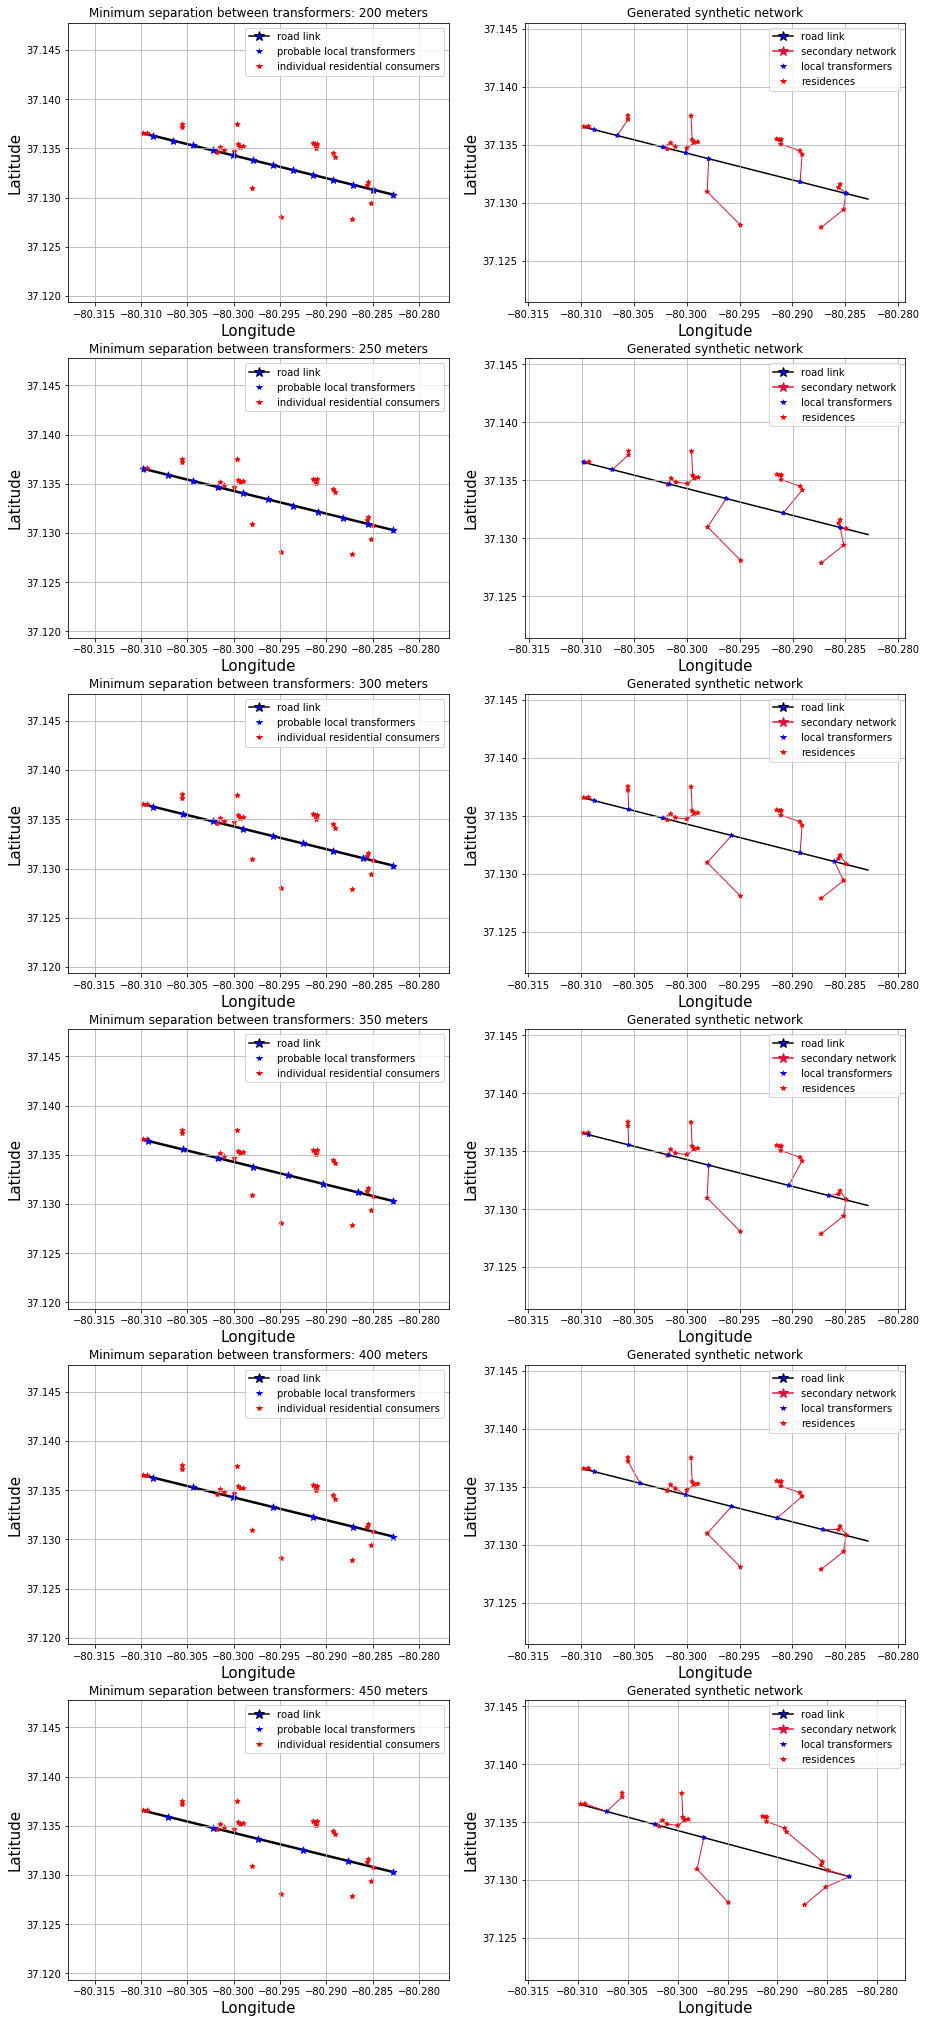

In [26]:
from IPython import display
%matplotlib inline
from matplotlib.lines import Line2D

link = (171528302, 171526182)
fig = plt.figure(figsize=(15,36))

for i,sep in enumerate([200,250,300,350,400,450]):
    forest,roots = spider_obj.generate_optimal_topology(link,minsep=sep)
    pos_nodes = nx.get_node_attributes(forest,'cord')
    
    # Display the problem
    H,T = spider_obj.get_nodes(link,minsep=sep)
    points = np.array([[homes.cord[h][0],homes.cord[h][1]] for h in H])
    ax1 = fig.add_subplot(6,2,2*i+1)
    nx.draw_networkx_edges(roads.graph,pos=roads.cord,edgelist=[link],ax=ax1,
                            width=2.5,edge_color='k')
    ax1.scatter([homes.cord[h][0] for h in H],[homes.cord[h][1] for h in H],c='r',
                s=25.0,marker='*')
    ax1.scatter([t[0] for t in list(T.values())],[t[1] for t in list(T.values())],
                c='b',s=50.0,marker='*')
    ax1.grid(b=True)
    ax1.set_xlabel("Longitude",fontsize=15)
    ax1.set_ylabel("Latitude",fontsize=15)
    ax1.set_title("Minimum separation between transformers: "+str(sep)+" meters",fontsize=12)
    leglines = [Line2D([0], [0], color='black', markerfacecolor='blue', marker='*',markersize=10),
                Line2D([0], [0], color='white', markerfacecolor='blue', marker='*',markersize=10),
                Line2D([0], [0], color='white', markerfacecolor='red', marker='*',markersize=10)]
    ax1.legend(leglines,['road link','probable local transformers',
                        'individual residential consumers'],
              loc='best',ncol=1,prop={'size': 10})

    # Display the secondary network
    ax2 = fig.add_subplot(6,2,2*i+2)
    ax2.grid(b=True)
    nx.draw_networkx_edges(roads.graph,pos=roads.cord,edgelist=[link],ax=ax2,
                           edge_color='k',width=1.5)
    nodelist = list(forest.nodes())
    colors = ['red' if n not in roots else 'blue' for n in nodelist]
    nx.draw_networkx(forest,pos=pos_nodes,edgelist=list(forest.edges()),
                     ax=ax2,edge_color='crimson',width=1,with_labels=False,
                     node_size=20.0,node_shape='*',node_color=colors)

    ax2.tick_params(left=True,bottom=True,labelleft=True,labelbottom=True)
    ax2.set_xlabel("Longitude",fontsize=15)
    ax2.set_ylabel("Latitude",fontsize=15)
    ax2.set_title("Generated synthetic network",fontsize=12)


    leglines = [Line2D([0], [0], color='black', markerfacecolor='blue', marker='*',markersize=10),
                Line2D([0], [0], color='crimson', markerfacecolor='crimson', marker='*',markersize=10),
                Line2D([0], [0], color='white', markerfacecolor='blue', marker='*',markersize=10),
                Line2D([0], [0], color='white', markerfacecolor='red', marker='*',markersize=10)]
    ax2.legend(leglines,['road link','secondary network','local transformers','residences'],
              loc='best',ncol=1,prop={'size': 10})
    ax2.autoscale(tight=True)

fig.savefig("{}{}.png".format(workPath,"output_step2_ensemble1"))